In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(5)

In [2]:
n = 10
arms = np.random.rand(n)
eps = 0.1 #probability of exploration action

In [3]:
def reward(prob):
    reward = 0
    for i in range(10):
        if random.random() < prob:
            reward += 1
    return reward

In [4]:
#initialize memory array; has 1 row defaulted to random action index
av = np.array([np.random.randint(0,(n+1)), 0]).reshape(1,2) #av = action-value

In [8]:
av

array([[5, 0]])

In [9]:
#greedy method to select best arm based on memory array
def bestArm(a):
    bestArm = 0 #default to 0
    bestMean = 0
    for u in a:
        avg = np.mean(a[np.where(a[:,0] == u[0])][:, 1]) #calculate mean reward for each action
        if bestMean < avg:
            bestMean = avg
            bestArm = u[0]
    return bestArm

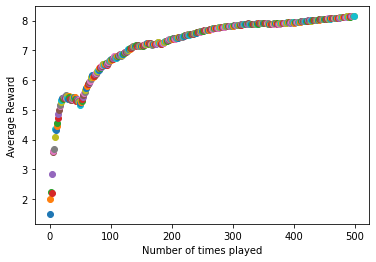

In [10]:
plt.xlabel("Number of times played")
plt.ylabel("Average Reward")
for i in range(500):
    if random.random() > eps: #greedy exploitation action
        choice = bestArm(av)
        thisAV = np.array([[choice, reward(arms[choice])]])
        av = np.concatenate((av, thisAV), axis=0)
    else: #exploration action
        choice = np.where(arms == np.random.choice(arms))[0][0]
        thisAV = np.array([[choice, reward(arms[choice])]]) #choice, reward
        av = np.concatenate((av, thisAV), axis=0) #add to our action-value memory array
    #calculate the mean reward
    runningMean = np.mean(av[:,1])
    plt.scatter(i, runningMean)


In [14]:
class UCBSocketTester( SocketTester ):

    def __init__(self, socket_order=socket_order, confidence_level=2.0 ):                  
        """ initialize the socket tester """                  
        super().__init__(socket = UCBSocket, 
                         socket_order = socket_order, 
                         confidence_level = confidence_level, 
                         number_of_stats = 3) # a UCB socket tester records 3 bits of information over a run
        
    def get_socket_stats( self, t ):
        """ record the current values of each socket """
        socket_stats = [[socket.Q,socket.n,socket.uncertainty(t+1)] for socket in self.sockets]
        return socket_stats   

    def select_socket( self, t ):
        """ choose the socket with the current highest UCB reward """
        socket_index = random_argmax([socket.sample(t+1) for socket in self.sockets])     
        return socket_index 

In [15]:
# do a single run with only 2 sockets to examine how the exploration and exploitation terms of the UCB equation vary
number_of_sockets = 2
number_of_steps = 20

# set the random seed to produce a recreatable graph
random.seed(0) 
np.random.seed(0)

tester = UCBSocketTester( socket_order[:number_of_sockets], confidence_level = 3.0 )
tester.run( number_of_steps )

(19, 114.77150488946722)

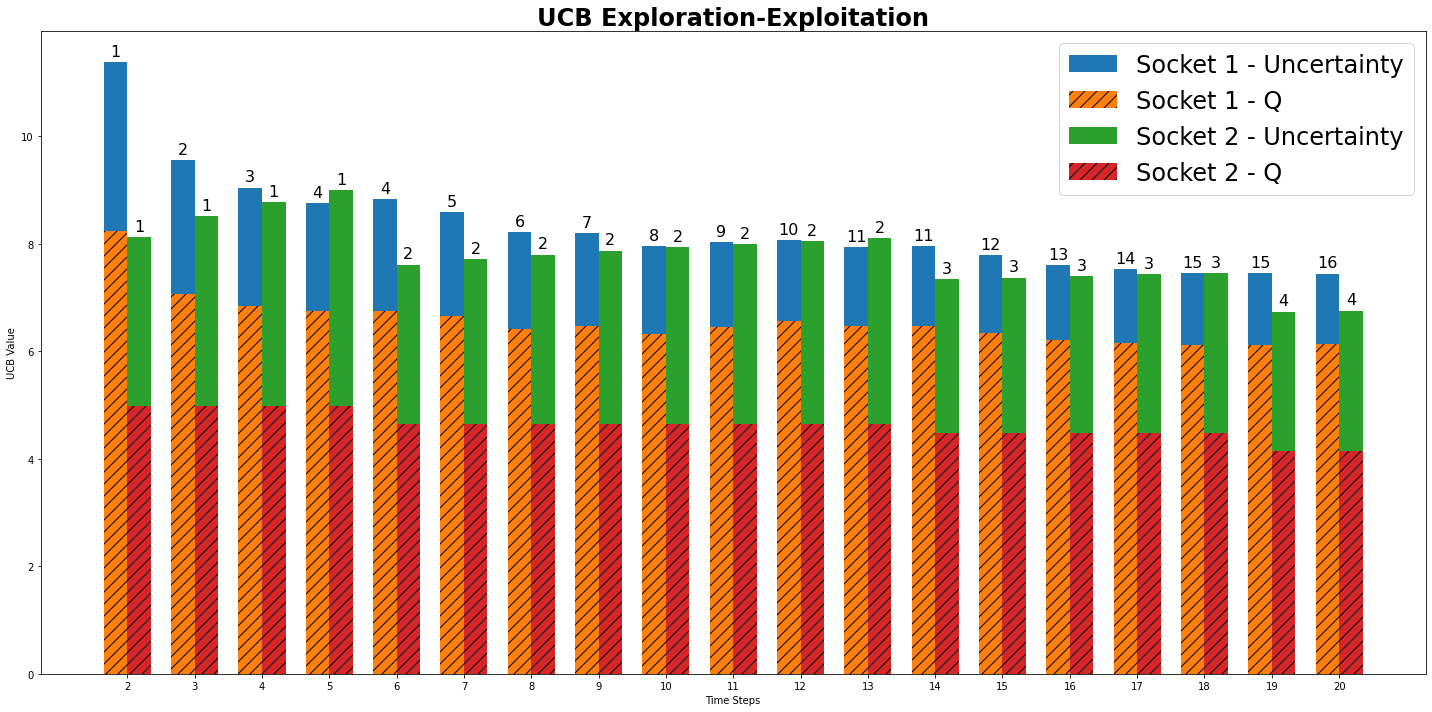

In [16]:
# get the parameters to graph from the socket stats
estimates = tester.socket_stats[:,:,0]
trials = tester.socket_stats[:,:,1]
uncertainty = tester.socket_stats[:,:,2]

# the label locations
# - start the examination after all sockets have been tried once
x = np.arange(len(estimates[:,0]))[2:]  
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(20, 10))

rects1 = [ plt.bar(x, uncertainty[2:,0]+estimates[2:,0], align='edge', width= -width, label='Socket 1 - Uncertainty'),
           plt.bar(x, estimates[2:,0], align='edge', width= -width, label='Socket 1 - Q', hatch='//')]

rects2 = [ plt.bar(x, uncertainty[2:,1]+estimates[2:,1], align='edge',width= width, label='Socket 2 - Uncertainty'),
           plt.bar(x, estimates[2:,1], align='edge',width= width, label='Socket 2 - Q', hatch='//')]

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('UCB Value')
ax.set_xlabel('Time Steps')
ax.set_title('UCB Exploration-Exploitation', fontsize=24, fontweight='bold')
ax.legend(fontsize=24)
ax.set_xticks(x)


def autolabel(rects,index,trials):
    """Attach a text label above each bar in *rects*, displaying its number of trials"""

    for i,rect in enumerate(rects[0]):
        height = rect.get_height()
        ax.annotate('{:.0f}'.format(trials[i+2,index]),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    size=16,
                    ha='center', va='bottom')  


autolabel(rects1,0,trials)
autolabel(rects2,1,trials)

fig.tight_layout()

# plt.savefig('ucb_exploration_exploitation.png')
plt.show()

https://github.com/WhatIThinkAbout/BabyRobot/blob/master/Multi_Armed_Bandits/Part%204%20-%20Upper%20Confidence%20Bound.ipynb

## Super Mario

In [2]:
import tensorflow as tf
import random
import gym
import numpy as np

from collections import deque

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

import gym_super_mario_bros
from gym_super_mario_bros.actions import RIGHT_ONLY
from nes_py.wrappers import JoypadSpace

from IPython.display import clear_output

from keras.models import save_model
from keras.models import load_model

import time

ModuleNotFoundError: No module named 'tensorflow'

In [18]:
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, RIGHT_ONLY)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(


In [19]:
total_reward = 0
done = True

In [20]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_space  = state_size
        self.action_space = action_size
        self.memory       = deque(maxlen=5000)
        self.gamma        = 0.8
        self.chosen_action = 0

        self.epsilon       = 1
        self.max_epsilon   = 1
        self.min_epsilon   = 0.01
        self.decay_epsilon = 0.0001

        self.main_network   = self.build_network()
        self.target_network = self.build_network()
        self.update_target_network()

    def build_network(self):
        model = Sequential()
        model.add(Conv2D(64, (4,4), strides=4, padding='same', input_shape=self.state_space))
        model.add(Activation('relu'))

        model.add(Conv2D(64, (4,4), strides=2, padding='same'))
        model.add(Activation('relu'))

        model.add(Conv2D(64, (3,3), strides=1, padding='same'))
        model.add(Activation('relu'))
        model.add(Flatten())

        model.add(Dense(512, activation='relu'))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(self.action_space, activation='linear'))

        model.compile(loss='mse', optimizer=Adam())

        return model

    def update_target_network(self):
        self.target_network.set_weights(self.main_network.get_weights())

    def act(self, state, on_ground):
        if on_ground < 83:   
            if random.uniform(0,1) < self.epsilon:
                self.chosen_action = np.random.randint(self.action_space)
                return self.chosen_action
            Q_value = self.main_network.predict(state)
            self.chosen_action = np.argmax(Q_value[0])
            return self.chosen_action
        else:
            return self.chosen_action
            
    def update_epsilon(self, episode):
        self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon) * np.exp(-self.decay_epsilon * episode)

    def train(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)

        for state, action, reward, next_state, done in minibatch:
            target = self.main_network.predict(state)

            if done:
                target[0][action] = reward
            else:
                target[0][action] = (reward + self.gamma * np.amax(self.target_network.predict(next_state)))
            
            self.main_network.fit(state, target, epochs=1, verbose=0)
    
    def store_transition(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    def get_pred_state(self, state):
        Q_values = self.main_network.predict(state)
        return np.argmax(Q_values[0])
        
    def load(self, name):
        self.main_network   = load_model(name)
        self.target_network = load_model(name)
        
    def save(self, name):
        save_model(self.main_network, name)

In [21]:
action_size = env.action_space.n
state_size  = (80,88,1)

from PIL import Image

def preprocess_state(state):
    image = Image.fromarray(state)
    image = image.resize((88,80))
    image = image.convert('L')
    image = np.array(image)

    return image

In [22]:
num_episode   = 1000000
num_timesteps = 400000
batch_size    = 64
debug_length  = 300

In [23]:
dqn = DQNAgent(state_size,action_size)

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-03-14 11:06:06.765693: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-14 11:06:06.766153: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [24]:
# Run this cell if you want to load from previous training. Skip if you want to start from scratch.
dqn.load('marioRL.h5')

In [25]:
stuck_buffer = deque(maxlen=debug_length)

for i in range(num_episode):
    Return    = 0
    done      = False
    time_step = 0
    on_ground = 79

    state = preprocess_state(env.reset())
    state = state.reshape(-1, 80,88,1)

    for t in range(num_timesteps):
        env.render()
        time_step += 1

        if t > 1 and stuck_buffer.count(stuck_buffer[-1]) > debug_length - 50:
            action = dqn.act(state, on_ground = 79)
        else:                            
            action = dqn.act(state, on_ground)

        next_state, reward, done, info = env.step(action)

        on_ground = info['y_pos']
        stuck_buffer.append(info['x_pos'])
        
        next_state = preprocess_state(next_state)
        next_state = next_state.reshape(-1, 80,88,1)

        dqn.store_transition(state, action, reward, next_state, done)
        state = next_state

        Return += reward
        print("Episode is: {}\nTotal Time Step: {}\nCurrent Reward: {}\nEpsilon is: {}".format(str(i), str(time_step), str(Return), str(dqn.epsilon)))

        clear_output(wait=True)
        
        if done:
            break

        if len(dqn.memory) > batch_size and i > 5:
            dqn.train(batch_size)
    
    dqn.update_epsilon(i)
    clear_output(wait=True)
    dqn.update_target_network()
    #save model
    dqn.save('marioRL.h5')

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:272: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


ValueError: not enough values to unpack (expected 5, got 4)

https://github.com/nicknochnack/MarioRL/blob/main/Mario%20Tutorial.ipynb 